# Assessing Dimensionality (on Tileset7) - July 2017
Created:  5 July 2018 <br>
Last update: 10 july 2018


### Comparing Manifold Learning Methods / Dimensionality Reduction Techniques
This notebook follows the Dimensionality notebook from Pierluggi 


## 1. Imports

In [1]:
# this will remove warnings messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# import
from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from matplotlib import offsetbox

from sklearn import manifold, datasets, decomposition, random_projection
from sklearn.preprocessing import LabelEncoder

import imgutils

In [2]:
# Re-run this cell if you altered imgutils
import importlib
importlib.reload(imgutils)

<module 'imgutils' from 'C:\\JADS\\SW\\Grad Proj\\sources\\imgutils.py'>

## 2. Import Crystal Image Data & Statistics
The data was labeled and exported to csv in the notebook realxtals1_dataeng1.ipynb

#### About the data:
The CSV contains the image files, slice information (sub-images) and associated statistics, which are the features for which a classifier needs to be found. 

The goal is to find the clustering in feature-space and use those to categorize the images. For this particular dataset, a single statistics could be used to label into three classes:<br>

A = subimage contains no crystal, <br>
B = part of subimage contains crystal, <br>
C = (most of) subimage contains crystal

But the labels have been added here for analyses, eventually the data will be unlabelled.

 



Import data:

In [3]:
df = pd.read_csv('../data/Crystals_Apr_12/Tileset7-2.csv', sep=';')
df.head()

,Unnamed: 0,filename,s_y,s_x,n_y,n_x,alias,img_mean,img_std,img_kurtosis,img_skewness,img_mode,img_std2,|img_mean|,|img_std|,|img_kurtosis|,|img_skewness|,|img_mode|,|img_std2|,class
0,0,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,0,0,4,4,img0_0-0,8955.557637,489.754848,4.163737,0.107415,8964.037109,0.054687,0.615795,-0.100998,0.082333,0.471479,0.204925,-0.122335,A
1,1,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,0,1,4,4,img0_0-1,8883.137305,501.739963,6.528225,-0.146746,8921.014648,0.056482,0.289248,-0.079451,0.504401,0.090672,0.006384,-0.095243,A
2,2,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,0,2,4,4,img0_0-2,8786.996070,327.512136,1.323241,-0.110828,8753.567871,0.037272,-0.144258,-0.392677,-0.424704,0.144487,-0.766354,-0.385181,A
3,3,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,0,3,4,4,img0_0-3,8679.430512,273.673569,0.112149,0.008591,8682.245605,0.031531,-0.629277,-0.489467,-0.640887,0.323411,-1.095494,-0.471832,A
4,4,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,1,0,4,4,img0_1-0,8982.867158,380.410977,0.168520,0.033678,8987.800781,0.042349,0.738935,-0.297575,-0.630825,0.360999,0.314590,-0.308566,A


Quick visual inspection:

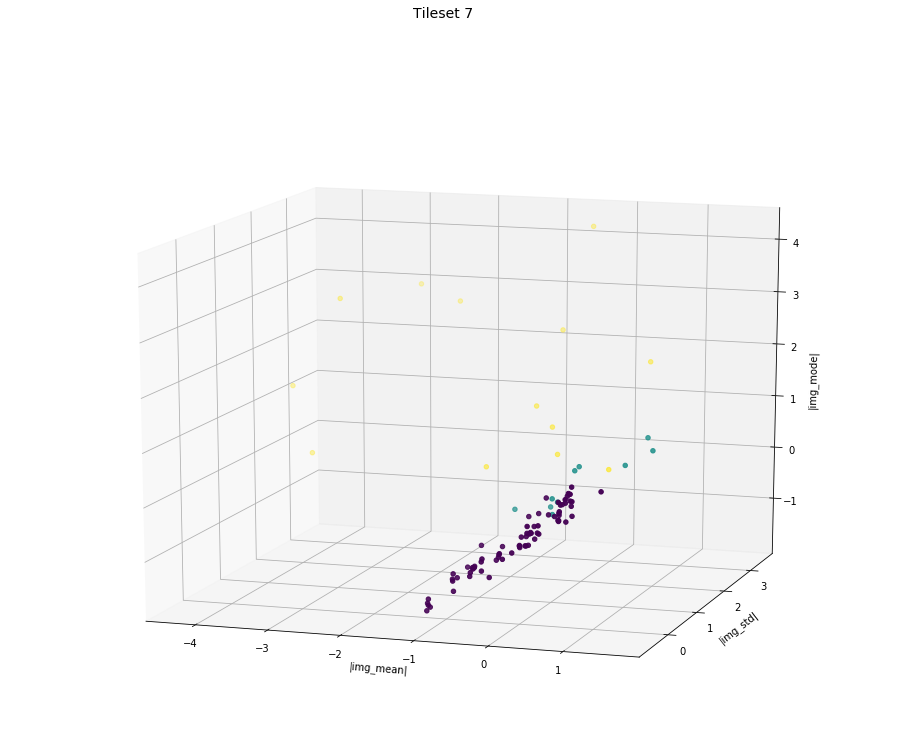

In [4]:
# trick to convert category labels into color codes
color = pd.DataFrame(df['class'].astype('category'))['class'].cat.codes

# plot it in 3 dimensions, choosing some stats
fig0 = plt.figure(figsize=(16, 12))
plt.suptitle("Tileset 7",fontsize=14)
ax = fig0.add_subplot(111, projection='3d')
ax.scatter(df['|img_mean|'], df['|img_std|'], df['|img_mode|'], c=color)
ax.set_xlabel('|img_mean|')
ax.set_ylabel('|img_std|')
ax.set_zlabel('|img_mode|')
ax.view_init(14, -72)

## 3. Vectorize the data for sklearn manifold methods

In [5]:
# convert labels into values
le = LabelEncoder()
df["|class|"] = le.fit_transform(df["class"])

In [6]:
# convert into X Y vectors:
feature_cols = ['|img_std|', '|img_mean|','|img_skewness|', '|img_mode|', '|img_kurtosis|']
X = df.loc[:,feature_cols]
Y = df.loc[:,'|class|']



## 4. Try two methods

### A. Random Projections

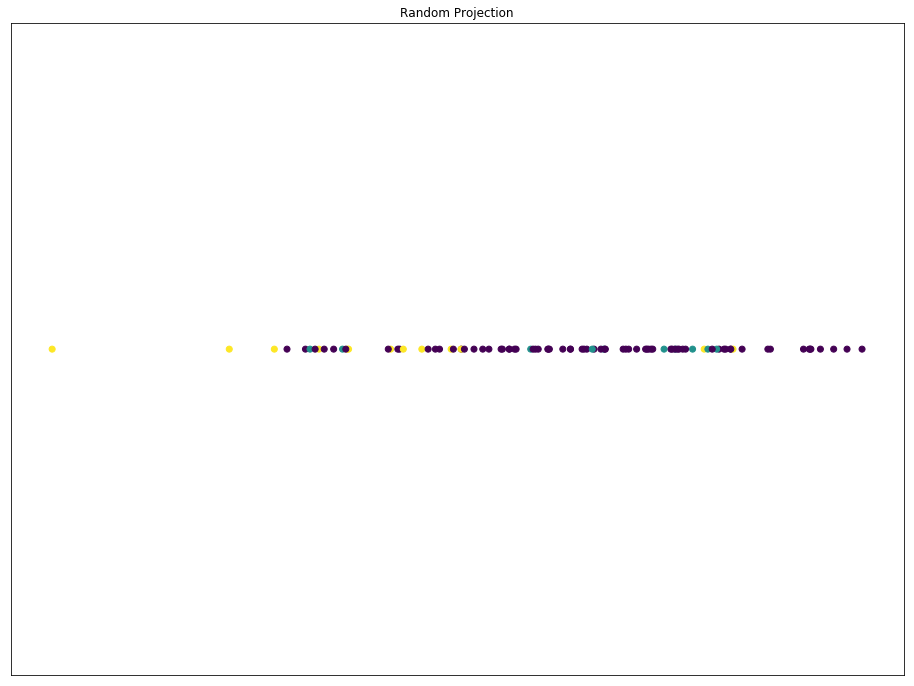

In [7]:

rp = random_projection.SparseRandomProjection(n_components=2, random_state=20)
 
X_rp = rp.fit_transform(X)

fig = plt.figure(figsize=(16, 12))
fig = plt.scatter(X_rp[:, 0], X_rp[:, 1], c=color)
fig = plt.title("Random Projection")
fig = plt.xticks([]), plt.yticks([])


does not go too well, plots it all on one line (if you reduce number of variables, it looks better)

### B. The Most Advanced: tSNE

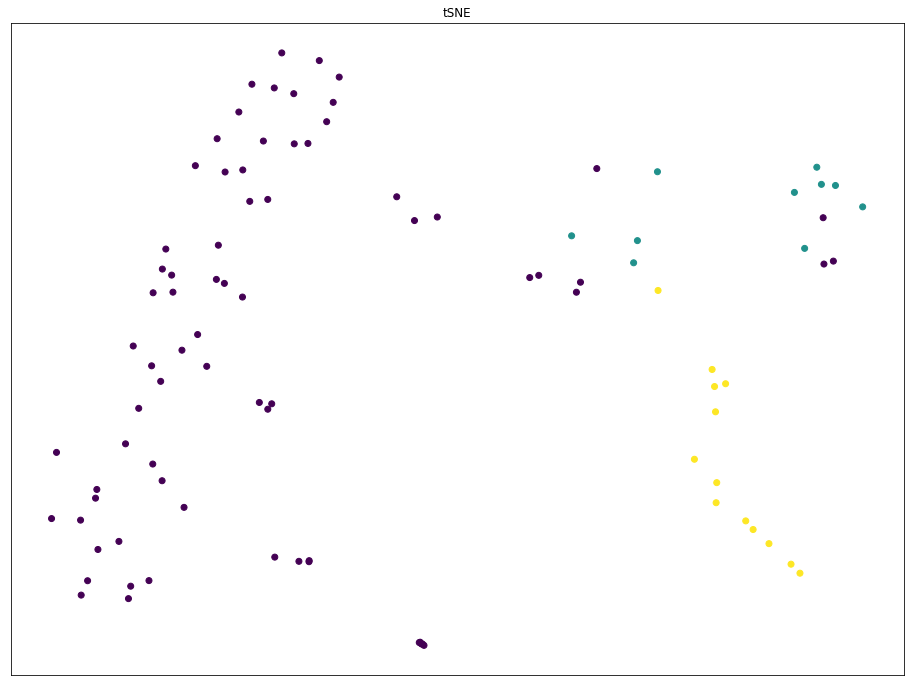

In [8]:
tsne = manifold.TSNE(n_components=2, random_state=0)

X_tsne = tsne.fit_transform(X)
  
fig = plt.figure(figsize=(16, 12))
fig = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color)
fig = plt.title("tSNE")
fig = plt.xticks([]), plt.yticks([])

## 5. Try a bunch of dimensionality reduction techniques

Computing Random Projection
Computing PCA
Computing Isomap
Computing MDS
Computing Specral Embedding
Computing t-SNE


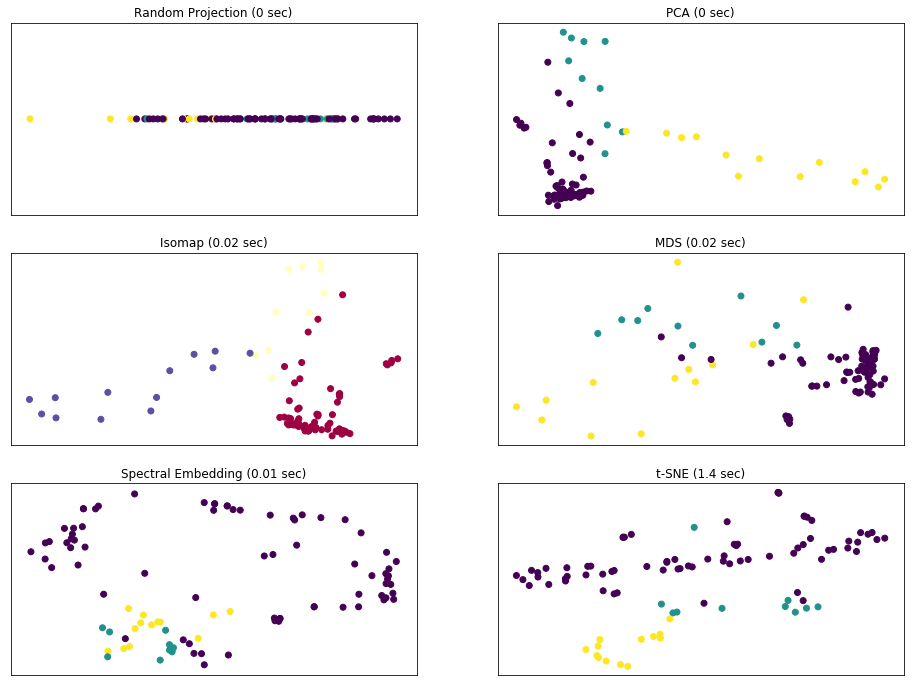

In [9]:
n_neighbors = 20
n_components = 2

fig = plt.figure(figsize=(16, 12))

#----------------------------------------------------------------------x
print("Computing Random Projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=20)
t0 = time()
X_rp = rp.fit_transform(X)
t1 = time()
plt.subplot(3,2,1)
plt.scatter(X_rp[:, 0], X_rp[:, 1], c=color)
plt.title("Random Projection (%.2g sec)" % (t1 - t0))
plt.xticks([]), plt.yticks([])

#----------------------------------------------------------------------
print("Computing PCA")
pca = decomposition.TruncatedSVD(n_components=2)
t0 = time()
X_pca = pca.fit_transform(X)
t1 = time()
plt.subplot(3,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=color)
plt.title("PCA (%.2g sec)" % (t1 - t0))
plt.xticks([]), plt.yticks([])

#----------------------------------------------------------------------
print("Computing Isomap")
iso = manifold.Isomap(n_neighbors, n_components)
t0 = time()
X_iso = iso.fit_transform(X)
t1 = time()
plt.subplot(3,2,3)
plt.scatter(X_iso[:, 0], X_iso[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
plt.xticks([]), plt.yticks([])

#----------------------------------------------------------------------
print("Computing MDS")
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
t0 = time()
X_mds = mds.fit_transform(X)
t1 = time()
plt.subplot(3,2,4)
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=color)
plt.title("MDS (%.2g sec)" % (t1 - t0))
plt.xticks([]), plt.yticks([])

#----------------------------------------------------------------------
print("Computing Specral Embedding")
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
t0 = time()
X_se = se.fit_transform(X)
t1 = time()
plt.subplot(3,2,5)
plt.scatter(X_se[:, 0], X_se[:, 1], c=color)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
plt.xticks([]), plt.yticks([])

#----------------------------------------------------------------------
print("Computing t-SNE")
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)
t1 = time()
plt.subplot(3,2,6)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.xticks([]), plt.yticks([]);

For this dataset, PCA and IsoMap look most promising

## 6. Improve visualization: plot with images as annotations


First a try-out with own code, snippets from the internet and reading into matplotlib API

In [10]:
from skimage.transform import resize
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import imgutils

def plot_with_imgs(X, df_img, class_field, title, ax=None, img_size=(24,24)):
    """Generates a scatter plot with thumbnails of the images corresponding to the data points. """
    
    # trick to convert category labels into color codes
    colors = pd.DataFrame(df_img[class_field].astype('category'))[class_field].cat.codes
    
    # with ax, an existing subplot can be filled
    if (ax==None):
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111)
        
    plt.scatter(X[:, 0], X[:, 1], c=colors)
   
    cmap = plt.cm.get_cmap('tab10')
   
    for i in range(X.shape[0]):
        img = imgutils.getimgslice(df_img, i)
        thumbnail = resize(img, img_size)
            
        imagebox = OffsetImage(thumbnail,cmap=plt.cm.gray_r)
        imagebox.image.axes = ax
        xy = (X[i,0],X[i,1])
        ab = AnnotationBbox(imagebox, xy, bboxprops =dict(edgecolor=cmap(colors[i])))
        #ab.set_zorder(0)
        ax.add_artist(ab)
        

    plt.title(title)
    plt.xticks([]), plt.yticks([])

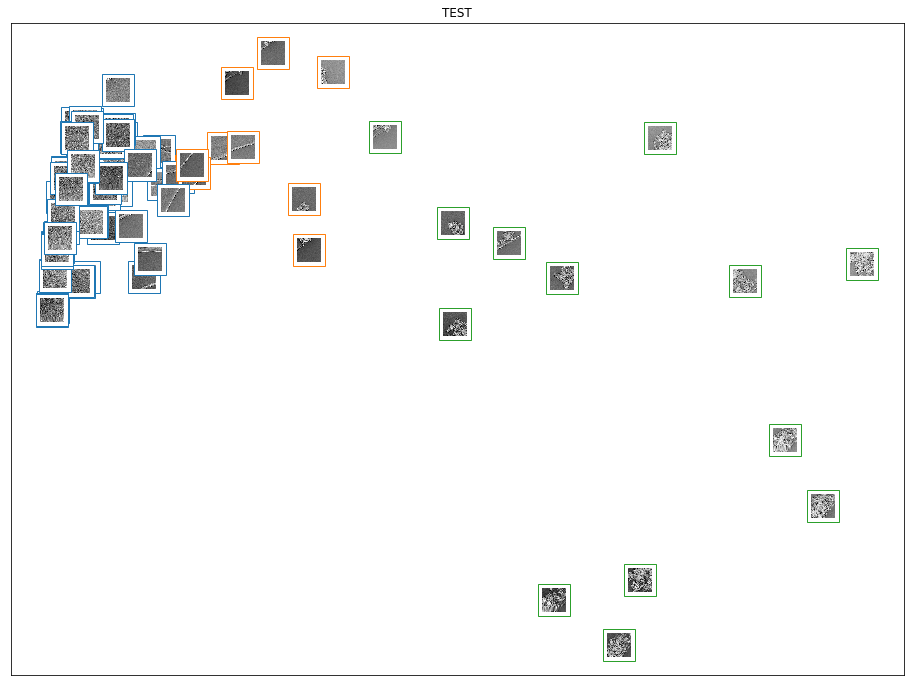

In [11]:
plot_with_imgs(X.values, df, 'class', 'TEST' )

Looks good.  Would be even better if I can combine this with the interactive plotting I created in imgutils.

So let's extend those methods with the image annotations...
(adjusting imgutils)
... and test the result

<IPython.core.display.Javascript object>


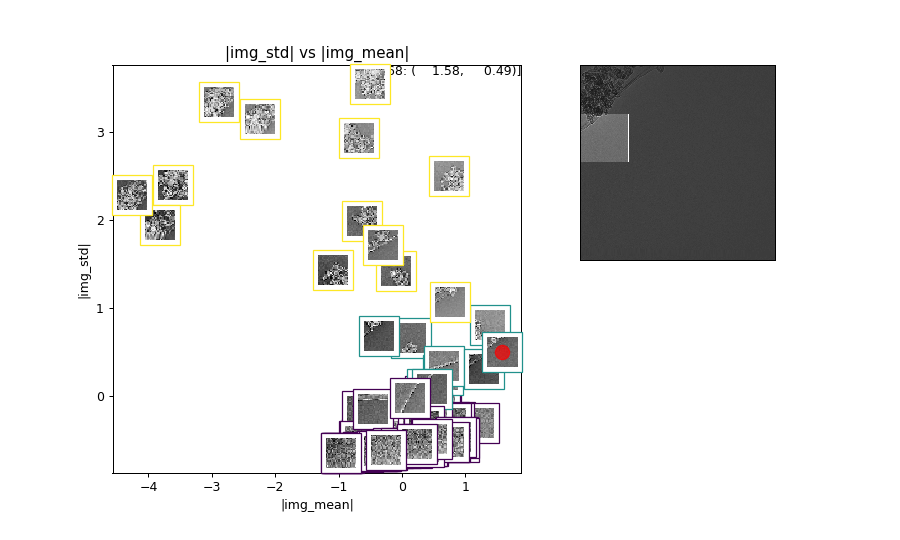

In [15]:
# now use the updated plotwithimg
%matplotlib notebook
imgutils.plotwithimg(df, '|img_mean|', '|img_std|', imgutils.highlightimgslice, cat_field='class', interactive=True, thumbnails=True)

<IPython.core.display.Javascript object>


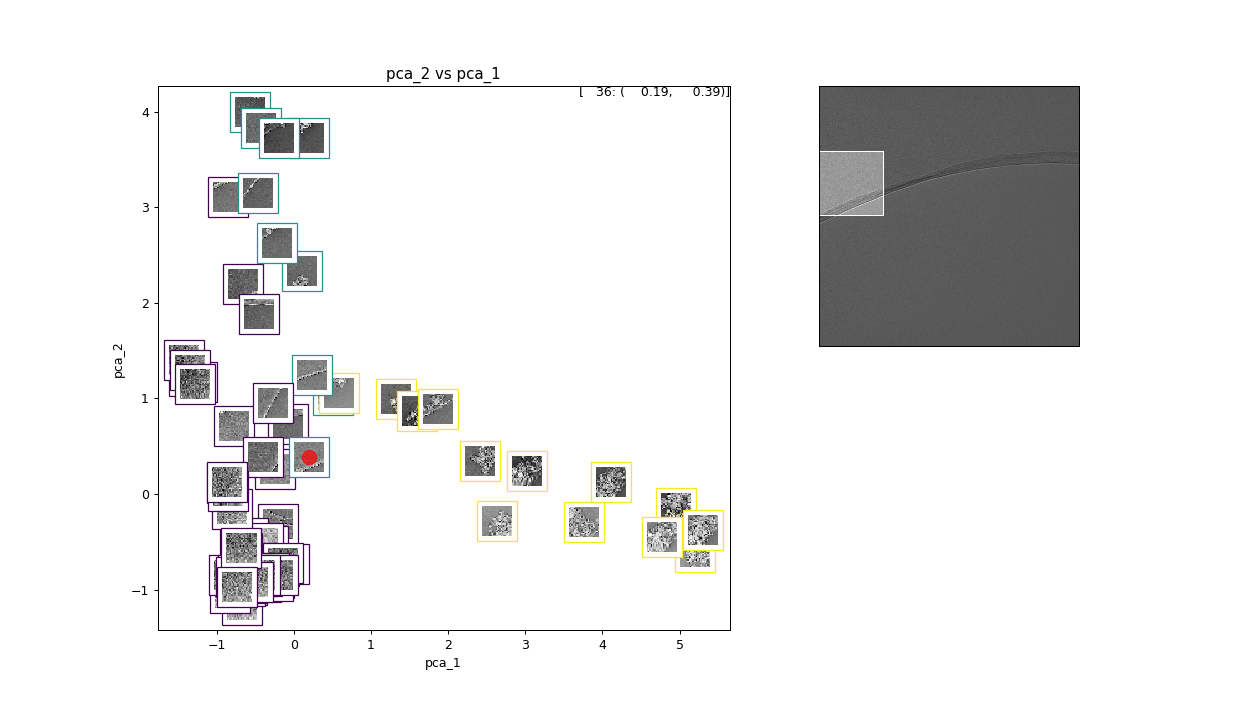

In [20]:
# and now the pca one
df['pca_1'] = X_pca[:,0].tolist()
df['pca_2'] = X_pca[:,1].tolist()

%matplotlib notebook
imgutils.plotwithimg(df, 'pca_1', 'pca_2', imgutils.highlightimgslice, cat_field='class', interactive=True, thumbnails=True, fig_size=(14,8))

## 7. Show the different techniques with the new visualization

Computing Random Projection


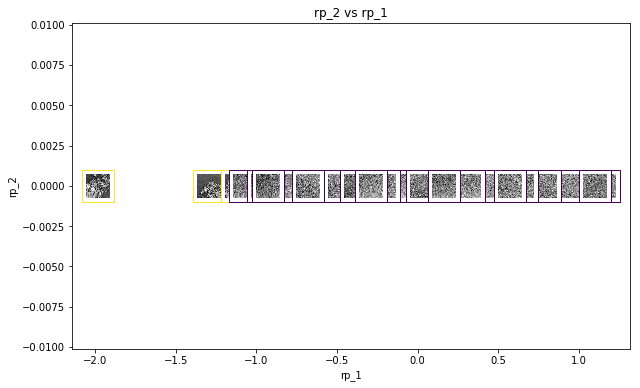

Computing PCA


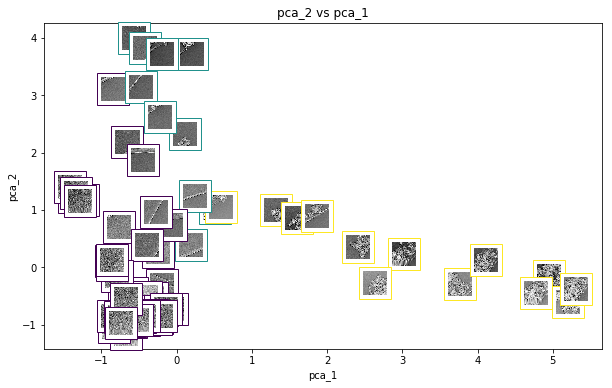

Computing Isomap


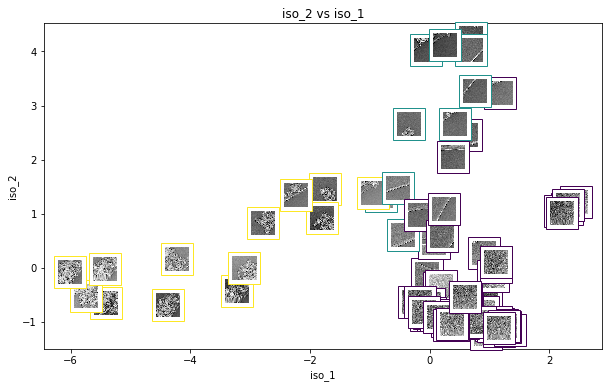

Computing MDS


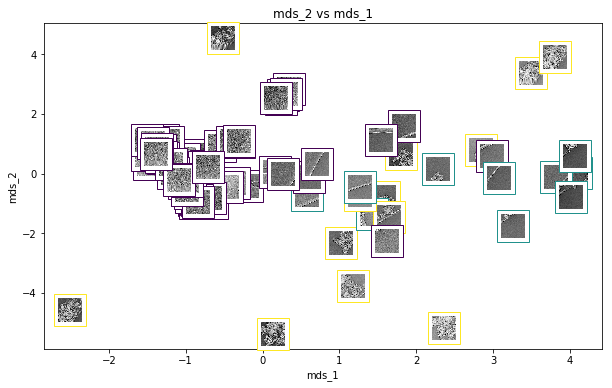

Computing Specral Embedding


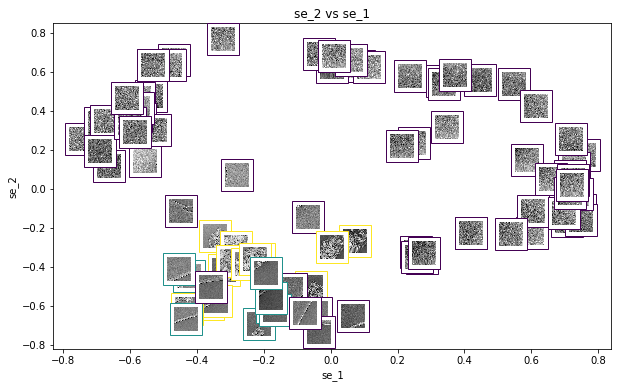

Computing t-SNE


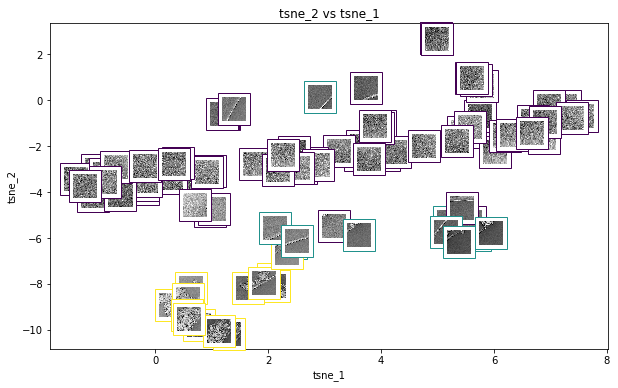

In [14]:
# Try now to use on all dimensionality reduction tricks:
n_neighbors = 20
n_components = 2

# as this needs to plot multiple in a single sell, disable interactivity
%matplotlib inline

#----------------------------------------------------------------------x
print("Computing Random Projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=20)
t0 = time()
X_rp = rp.fit_transform(X)
t1 = time()
title ="Random Projection (%.2g sec)" % (t1 - t0) 
fieldname1 = 'rp_1'
fieldname2 = 'rp_2'
df[fieldname1] = X_rp[:,0].tolist()
df[fieldname2] = X_rp[:,1].tolist()
imgutils.plotwithimg(df, fieldname1, fieldname2, imgutils.getimgslice, cat_field='class', thumbnails=True, interactive=False)

#----------------------------------------------------------------------
print("Computing PCA")
pca = decomposition.TruncatedSVD(n_components=2)
t0 = time()
X_pca = pca.fit_transform(X)
t1 = time()
title = "PCA (%.2g sec)" % (t1 - t0)
fieldname1 = 'pca_1'
fieldname2 = 'pca_2'
df[fieldname1] = X_pca[:,0].tolist()
df[fieldname2] = X_pca[:,1].tolist()
imgutils.plotwithimg(df, fieldname1, fieldname2, imgutils.getimgslice, cat_field='class', thumbnails=True, interactive=False)

#----------------------------------------------------------------------
print("Computing Isomap")
iso = manifold.Isomap(n_neighbors, n_components)
t0 = time()
X_iso = iso.fit_transform(X)
t1 = time()
title = "Isomap (%.2g sec)" % (t1 - t0)
fieldname1 = 'iso_1'
fieldname2 = 'iso_2'
df[fieldname1] = X_iso[:,0].tolist()
df[fieldname2] = X_iso[:,1].tolist()
imgutils.plotwithimg(df, fieldname1, fieldname2, imgutils.getimgslice, cat_field='class', thumbnails=True, interactive=False)

#----------------------------------------------------------------------
print("Computing MDS")
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
t0 = time()
X_mds = mds.fit_transform(X)
t1 = time()
title ="MDS (%.2g sec)" % (t1 - t0) 
fieldname1 = 'mds_1'
fieldname2 = 'mds_2'
df[fieldname1] = X_mds[:,0].tolist()
df[fieldname2] = X_mds[:,1].tolist()
imgutils.plotwithimg(df, fieldname1, fieldname2, imgutils.getimgslice, cat_field='class', thumbnails=True, interactive=False)

#----------------------------------------------------------------------
print("Computing Specral Embedding")
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
t0 = time()
X_se = se.fit_transform(X)
t1 = time()
title = "Spectral Embedding (%.2g sec)" % (t1 - t0)
fieldname1 = 'se_1'
fieldname2 = 'se_2'
df[fieldname1] = X_se[:,0].tolist()
df[fieldname2] = X_se[:,1].tolist()
imgutils.plotwithimg(df, fieldname1, fieldname2, imgutils.getimgslice, cat_field='class', thumbnails=True, interactive=False)


#----------------------------------------------------------------------
print("Computing t-SNE")
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)
t1 = time()
title = "t-SNE (%.2g sec)" % (t1 - t0)
fieldname1 = 'tsne_1'
fieldname2 = 'tsne_2'
df[fieldname1] = X_tsne[:,0].tolist()
df[fieldname2] = X_tsne[:,1].tolist()
imgutils.plotwithimg(df, fieldname1, fieldname2, imgutils.getimgslice, cat_field='class', thumbnails=True, interactive=False)



### Nice, these type of plots are going to help with the harder data sets.



## 8. Next Steps:
- Try the 'feature selection' notebook approach on this data set 
- Try unsupervised learning on this data set (maybe first apply PCA or IsoMap) 
- Repeat this notebook on harder dataset


Michael Janus, 5 July 2018